In [219]:
import pandas as pd
from sklearn import ensemble
from sklearn import tree
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import Imputer
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import string
sns.set_context('notebook')

In [220]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

There are 7 cover types -- how many of each example do we have in the training set?

2160


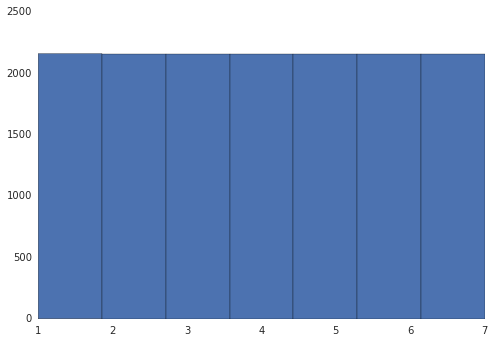

In [221]:
print (train.shape[0]//7)
train['Cover_Type'].hist(bins=7)

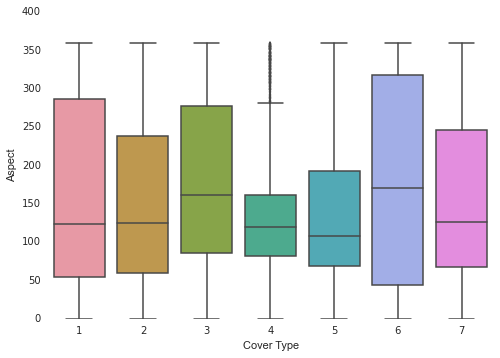

In [222]:
aspectList=[[],[],[],[],[],[],[]]
for k in range(train.shape[0]):
    aspectList[train.ix[k,'Cover_Type']-1].append(train.ix[k,'Aspect'])

sns.boxplot(aspectList)
plt.xlabel('Cover Type')
plt.ylabel('Aspect')

Aspect doesn't really tell us a whole lot -- Cover Type 4 falls in a smaller range than the others but not much spread

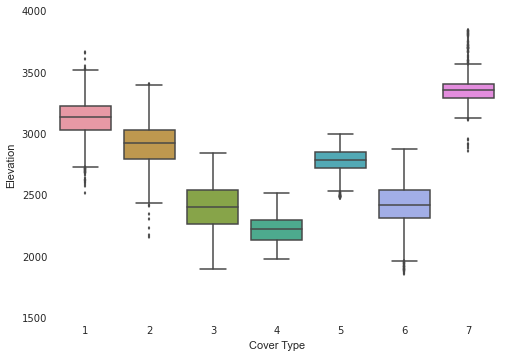

In [223]:
elevationList=[[],[],[],[],[],[],[]]
for k in range(train.shape[0]):
    elevationList[train.ix[k,'Cover_Type']-1].append(train.ix[k,'Elevation'])

sns.boxplot(elevationList)
plt.xlabel('Cover Type')
plt.ylabel('Elevation')

Looks like there's some clear clustering of cover types vs elevation

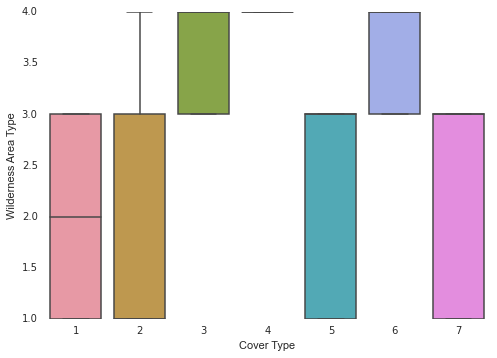

In [224]:
def decodeWA(dataset, index):
    if dataset.ix[index,'Wilderness_Area1'] == 1:
        return 1
    elif dataset.ix[index,'Wilderness_Area2'] == 1:
        return 2
    if dataset.ix[index,'Wilderness_Area3'] == 1:
        return 3
    if dataset.ix[index,'Wilderness_Area4'] == 1:
        return 4
    
waList=[[],[],[],[],[],[],[]]
for k in range(train.shape[0]):
    waList[train.ix[k,'Cover_Type']-1].append(decodeWA(train,k))

sns.boxplot(waList)
plt.xlabel('Cover Type')
plt.ylabel('Wilderness Area Type')
# TODO -- are there covertypes that do NOT show up at all in particular wilderness areas?

Look at combining waList and Elevation

([<matplotlib.axis.XTick at 0x12dc18dd0>,
 <a list of 4 Text xticklabel objects>)

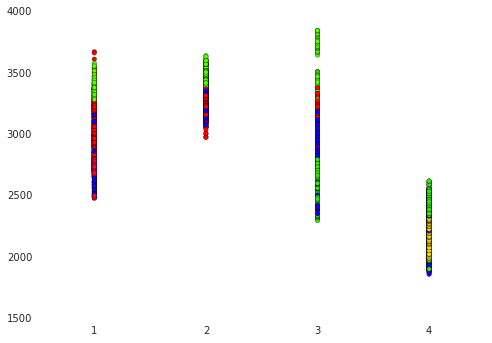

In [236]:
elevations=train.ix[:,'Elevation']
waCode=[]
for k in range(train.shape[0]):
    waCode.append(decodeWA(train,k))
plt.scatter(waCode, elevations, c=train.ix[:,'Cover_Type'],cmap='prism')
plt.xticks([1,2,3,4])

But the wilderness area codes might be tied to elevation and this might not be providing any new information, although clearly Wildewness_Area 4 is different

In [241]:
train.ix[:3,:11]

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,1,2596,51,3,258,0,510,221,232,148,6279
1,2,2590,56,2,212,-6,390,220,235,151,6225
2,3,2804,139,9,268,65,3180,234,238,135,6121
3,4,2785,155,18,242,118,3090,238,238,122,6211


Plot histograms of the non-binary features.

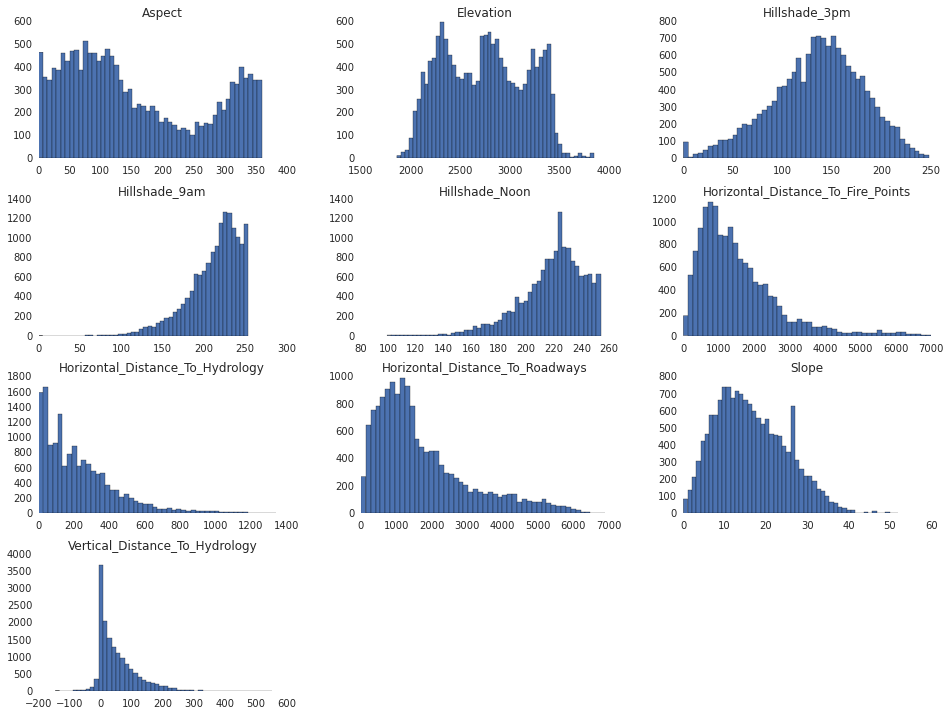

In [242]:
train.ix[:,1:11].hist(figsize=(16,12),bins=50)
plt.show()

Establish a baseline score using the default sklearn decision tree classifier. This had an accuracy of **0.66468** on Kaggle.

In [243]:
def getImportance(classifier,covariates,title):

    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
    indices=np.argsort(importances)[::-1][:10]
    # Plot the feature importances of the forest
    plt.figure()
    plt.title(title,fontsize=15)
    plt.bar(range(10), importances[indices],
       yerr=std[indices], align="center",alpha=.5,color="BrBG")
    plt.xticks(range(10), np.asarray(covariates)[indices], rotation=45, rotation_mode="anchor", ha="right")
    plt.xlim([-1, 10])
    plt.show()


In [244]:
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y)

with open("decision_tree_baseline.csv", "wt") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(clf.predict(X_test))):
        outfile.write("%s,%s\n"%(test_ids[e],val))


Using Random Forest Classifier without Feature Engineering. This had an accuracy of >70% on Kaggle

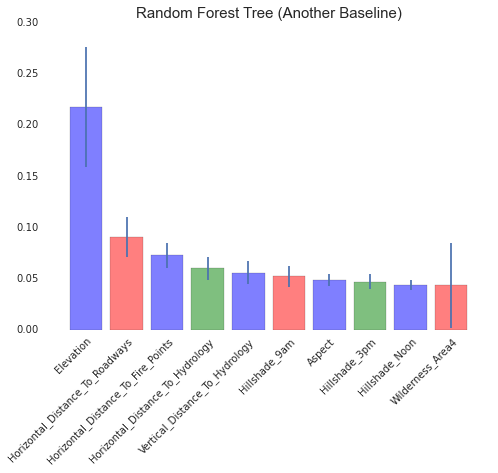

In [245]:
randf = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True)
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']
randf.fit(X_train, y)
getImportance(randf, list(feature_cols), "Random Forest Tree (Another Baseline)") 


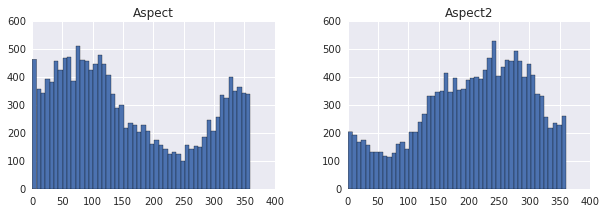

In [14]:
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

train['Aspect2'] = train.Aspect.map(r)
test['Aspect2'] = test.Aspect.map(r)

train.ix[:,[2,56]].hist(figsize=(10,3),bins=50)
plt.show()


Scatter Plot for top 5 features

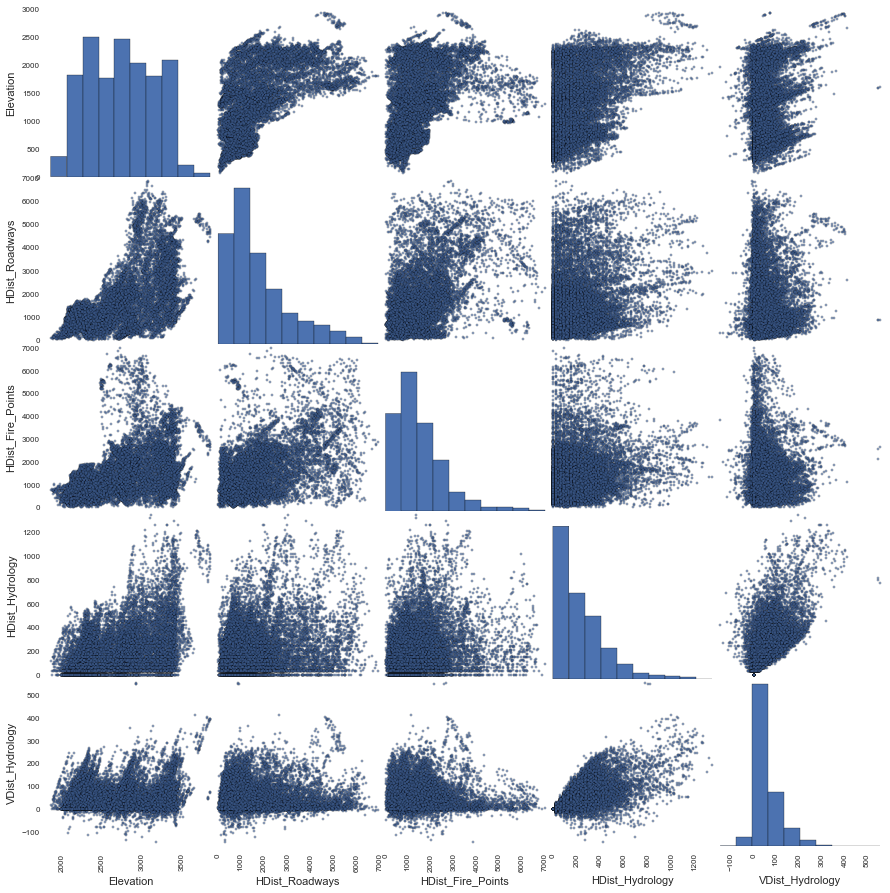

In [127]:
top5=train[['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']]
top5.columns=top5.columns.map(lambda x: x.replace('Horizontal_Distance_To','HDist'))
top5.columns=top5.columns.map(lambda x: x.replace('Vertical_Distance_To','VDist'))
scatter_matrix(top5,figsize=(15, 15),alpha=.6)
plt.show()

That the Horizontal Distance to Roadways increases with Elevation should come as little surprise -- at higher elevations fewer roads will be built. Otherwise the only clear trend is that horizontal and vertcal distances to hydrology appear correlated.

Plot the graph of Elevation versus Vertical_Distance_to_Hydrology color coded by cover type.

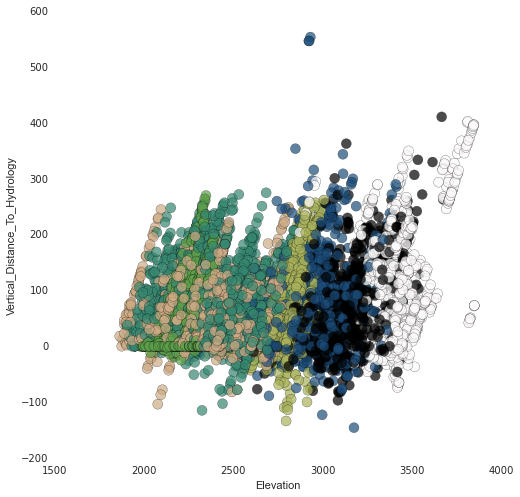

In [249]:
def plotc(c1,c2):

    fig = plt.figure(figsize=(8,8))
    sel = np.array(list(train.Cover_Type.values))
    plt.scatter(c1, c2, c=sel, s=100,cmap=plt.cm.gist_earth,alpha=.7)
    plt.ylabel(c2.name)
    
plotc(train.Elevation, train.Vertical_Distance_To_Hydrology)

Create two features: difference between Elevation and Vertical Distance to Hydrology and difference between Elevation and one-fifth of the Horizontal Distance to Hydrology.

In [247]:
train['EVDtH'] = train.Elevation-train.Vertical_Distance_To_Hydrology
test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology

train['EHDtH'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
test['EHDtH'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2


Plot the difference between Elevation and one-fifth of the Horizontal Distance to Hydrology versus Horizontal Distance to Hydrology.

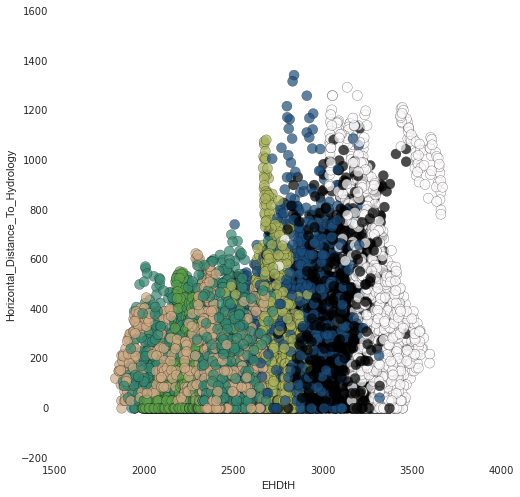

In [251]:

plotc(train.EHDtH, train.Horizontal_Distance_To_Hydrology)

Some apparent segregation in this new variable

In [252]:
train['Distanse_to_Hydrolody'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
test['Distanse_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])

Hill Shade Scatter Plot - There is a clear negative correlation between HillShade_9am and HillShade_3pm, which would make sense for a west-facing slope in Colorado

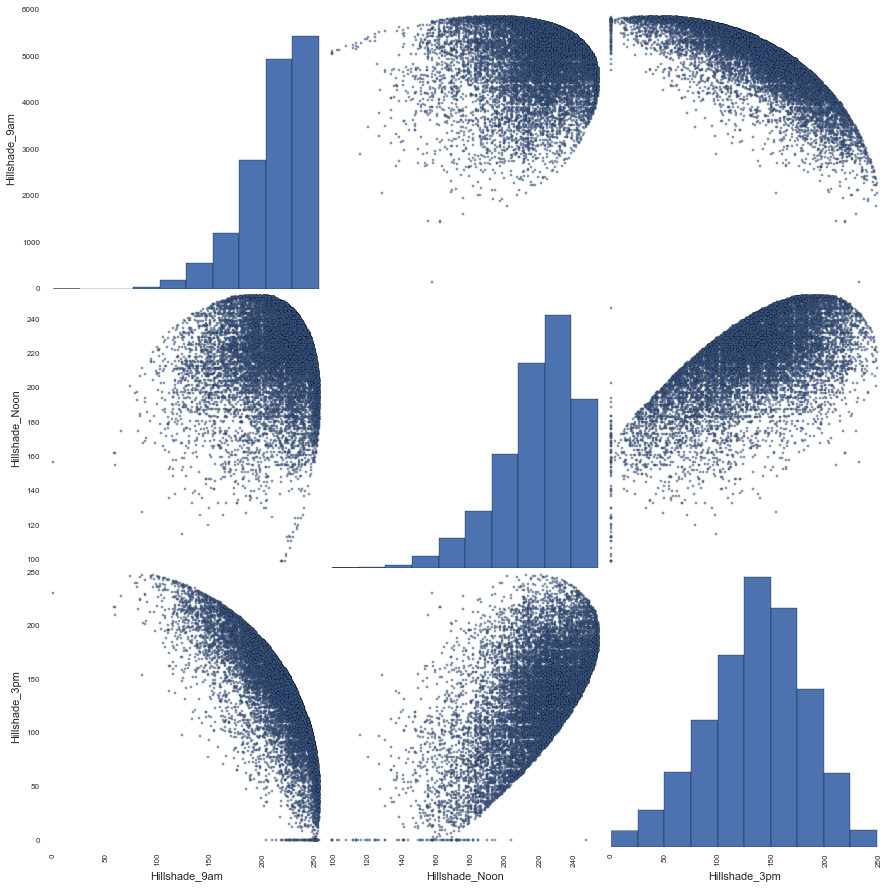

In [253]:
hill_shade = train[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']] 
scatter_matrix(hill_shade, alpha=0.6, figsize=(15, 15))
plt.show()

Plot the Hillshade at 3 p.m. values versus Hillshade at 12 p.m. There are Hillshade at 3 p.m. values that are zero.

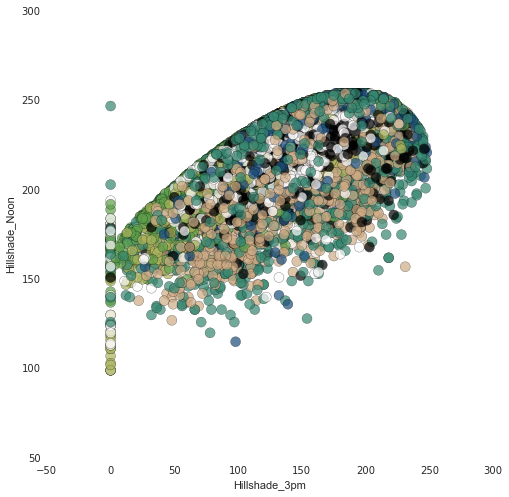

In [254]:
plotc(train.Hillshade_3pm, train.Hillshade_Noon)

Clearly, there are hillshade 3pm values that are zero

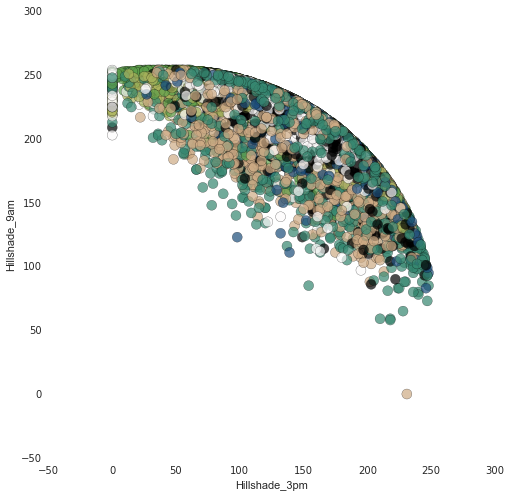

In [255]:
plotc(train.Hillshade_3pm, train.Hillshade_9am)

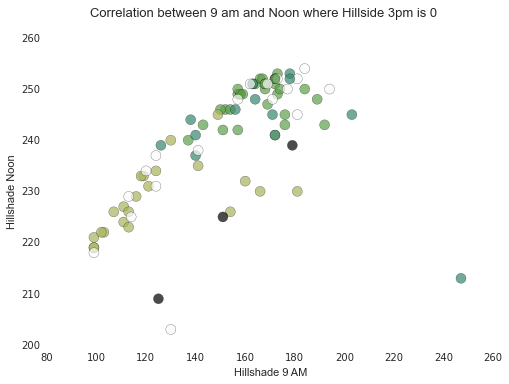

In [256]:
Hill_shade_3pm_missing=train[train.Hillshade_3pm==0]
sel = np.array(list(Hill_shade_3pm_missing.Cover_Type.values))
plt.scatter(Hill_shade_3pm_missing.Hillshade_Noon, Hill_shade_3pm_missing.Hillshade_9am, c=sel, s=100,cmap=plt.cm.gist_earth,alpha=.7)
plt.suptitle('Correlation between 9 am and Noon where Hillside 3pm is 0', fontsize=13)
plt.xlabel('Hillshade 9 AM') 
plt.ylabel('Hillshade Noon')


plt.show()

In [259]:
hillshadeBad3pmId = train[train.Hillshade_3pm == 0.0].Id

In [260]:
hillshadeBad3pmId.shape

(88,)

In [261]:
print train.Hillshade_Noon[hillshadeBad3pmId][:10]
# maybe replace with the average of samples with the same noon hillshade

Id
1376    235
1412    227
1417    183
1420    239
1424    166
1425    224
1428    183
1432    205
1440    160
1441    223
Name: Hillshade_Noon, dtype: int64


Using Median Values to fill missing values for Hillshade_3pm

In [262]:
temp=train.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]
del temp['Cover_Type']

X,y,X_train_data_missing,y_train_data_missing= temp[temp.Hillshade_3pm!=0].values[:,:-1],temp[temp.Hillshade_3pm!=0].values[:,-1:].ravel(),temp[temp.Hillshade_3pm==0].values[:,:-1],temp[temp.Hillshade_3pm==0].values[:,-1:].ravel()


X_train,X_test,y_train,y_test=train_test_split(X,y)
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
imp.fit(X_train,y_train)
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=imp.transform(X_train_data_missing)
train.Hillshade_3pm=temp.Hillshade_3pm


temp=test.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]


X_test_data_missing= temp[temp.Hillshade_3pm==0].values[:,:-1]
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=imp.transform(X_test_data_missing)
test.Hillshade_3pm=temp.Hillshade_3pm


In [263]:
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id','Horizontal_Distance_To_Htdrology',
                                                            'Vertical_Distance_To_Hydrology']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']

forest = ensemble.ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0)


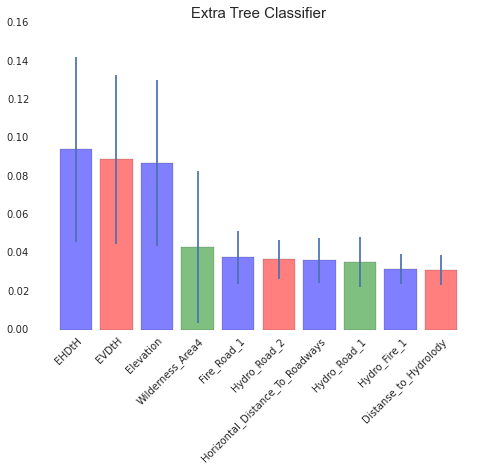

In [264]:
forest.fit(X_train, y)
getImportance(forest, list(X_train), "Extra Tree Classifier") 
with open('FEbenchmark2.csv', "wt") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(forest.predict(X_test))):
        outfile.write("%s,%s\n"%(test_ids[e],val))

This version scored an accuracy of **0.81003**

In [265]:
X_train['south_face'] = [180 - a if a <=180 else a - 180  for a in X_train.Aspect]
X_train['south_x_slope'] = X_train.south_face * X_train.Slope
X_test['south_face']= [180 - a if a <=180 else a - 180  for a in X_test.Aspect]
X_test['south_x_slope'] = X_test.south_face * X_test.Slope

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the cav

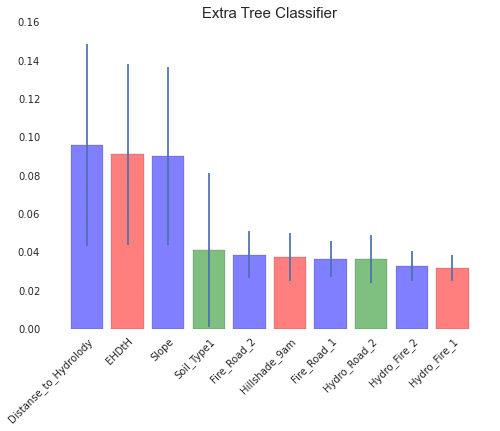

In [270]:
feature2_cols = [col for col in train.columns if col not in ['Cover_Type','Id','Horizontal_Distance_To_Htdrology',
                                                            'Vertical_Distance_To_Hydrology','Aspect']]

X_train2 = train[feature2_cols]
X_test2 = test[feature2_cols]
forest2 = ensemble.ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0)

forest2.fit(X_train2, y)
getImportance(forest2, list(X_train2)[1:], "Extra Tree Classifier ") 

In [272]:
with open('fe2_south.csv', "wb") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(forest2.predict(X_test2))):
        outfile.write("%s,%s\n"%(test_ids[e],val))

This version scored an accuracy of **0.81108**

How well should we be able to do?

This is a pretty aggressive train/test split, and it would be helpful to benchmark against the full dataset.

The dataset is available at https://archive.ics.uci.edu/ml/datasets/Covertype

There is also a spark/MLLib implementation and walkthrough at https://github.com/sryza/aas/blob/master/ch04-rdf/src/main/scala/com/cloudera/datascience/rdf/RunRDF.scala 

Let's pull out a subset of this and look at the accuracy of MLLib's RandomForest classifier for different splits

Here's some scala code adapted from the Advnaced Analytics in Spark github repo (URL above)

    import org.apache.spark.mllib.evaluation.MulticlassMetrics
    import org.apache.spark.mllib.linalg.Vectors
    import org.apache.spark.mllib.regression.LabeledPoint
    import org.apache.spark.mllib.tree.{RandomForest, DecisionTree}
    import org.apache.spark.mllib.tree.model.DecisionTreeModel
    import org.apache.spark.rdd.RDD
    import org.apache.spark.{SparkConf, SparkContext}
    object RunRDF {

      def main(args: Array[String]): Unit = {
        val sc = new SparkContext(new SparkConf().setAppName("RDF"))
        val rawData = sc.textFile("covtype.data")

        val data = rawData.map { line =>
              val values = line.split(',').map(_.toDouble)
              val featureVector = Vectors.dense(values.init)
              val label = values.last - 1
              LabeledPoint(label, featureVector)
         }

        evaluateForest(rawData)
      }
  
      def unencodeOneHot(rawData: RDD[String]): RDD[LabeledPoint] = {
           rawData.map { line =>
               val values = line.split(',').map(_.toDouble)
                // Which of 4 "wilderness" features is 1
               val wilderness = values.slice(10, 14).indexOf(1.0).toDouble
               // Similarly for following 40 "soil" features
               val soil = values.slice(14, 54).indexOf(1.0).toDouble
               // Add derived features back to first 10
               val featureVector = Vectors.dense(values.slice(0, 10) :+ wilderness :+ soil)
               val label = values.last - 1
               LabeledPoint(label, featureVector)
            }
       }
  
      def evaluateForest(rawData: RDD[String]): Unit = {

          val data = unencodeOneHot(rawData)
          // Vary the train/test split here to look at accuracy entitlement
          val Array(trainData, cvData) = data.randomSplit(Array(0.9, 0.1))
          trainData.cache()
          cvData.cache()

          val forest = RandomForest.trainClassifier(
                 trainData, 7, Map(10 -> 4, 11 -> 40), 20, "auto", "entropy", 30, 300)

          val predictionsAndLabels = cvData.map(example =>
                      (forest.predict(example.features), example.label))
          println(new MulticlassMetrics(predictionsAndLabels).precision)

        }
    }

With a 90/10 split, we get 96.5% accuracy

70/30: 96.0%

50/50: 95.2%

30/70: 94.0%

10/90: 89.5%

5/95: 86.3%

2/98: 81.1%

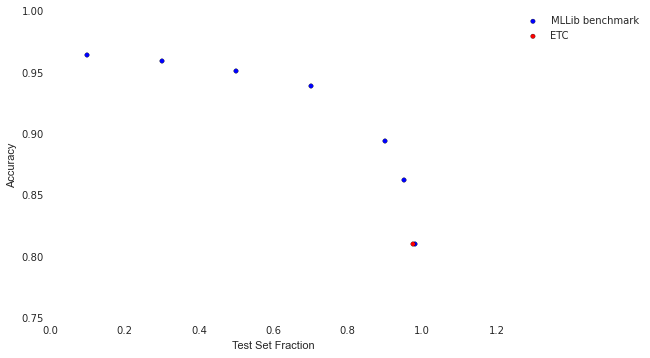

In [273]:
testsplit=[0.1,0.3,0.5,0.7,0.9,0.95,0.98]
rfacc=[0.965,0.960,0.952,0.940,0.895,0.863,0.811]
plt.scatter(testsplit,rfacc, label='MLLib benchmark')
plt.scatter(float(test.shape[0])/float(train.shape[0]+test.shape[0]),0.81108, c='red',label='ETC')
plt.grid()
plt.xlabel('Test Set Fraction')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Let's look at some of the ETC parameters

In [40]:
forest3 = ensemble.ExtraTreesClassifier(n_estimators=300, criterion='entropy', max_depth=30, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0)

forest3.fit(X_train, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=30, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [41]:
with open('fe_etc_mllib.csv', "wb") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(forest3.predict(X_test))):
        outfile.write("%s,%s\n"%(test_ids[e],val))

Scored **0.80450** -- not better than original ETC parameters

In [46]:
print X_train.ix[:3,10:14]

   Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4
0                 1                 0                 0                 0
1                 1                 0                 0                 0
2                 1                 0                 0                 0
3                 1                 0                 0                 0


In [52]:
X_train.ix[0,10:14]

Wilderness_Area1    1
Wilderness_Area2    0
Wilderness_Area3    0
Wilderness_Area4    0
Name: 0, dtype: float64

In [53]:
print train.columns[:10]

Index([u'Id', u'Elevation', u'Aspect', u'Slope', u'Horizontal_Distance_To_Hydrology', u'Vertical_Distance_To_Hydrology', u'Horizontal_Distance_To_Roadways', u'Hillshade_9am', u'Hillshade_Noon', u'Hillshade_3pm'], dtype='object')


In [54]:
wacols = [col for col in train.columns if 'Wilderness' in col]

In [55]:
print wacols

['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']


In [56]:
wa_train = train[wacols]

In [58]:
wa_train.shape

(15120, 4)

In [63]:
wa_train.ix[:5,:]

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0


In [28]:
clf=SGDClassifier(loss='log',penalty='l1',class_weight='auto',n_iter=60)
clf.fit(X_train,y)
testPred=clf.predict_log_proba(X_test)
print testPred.shape

(565892, 7)


In [71]:
f2pred=forest2.predict(X_test)

In [73]:
f2pred.shape

(565892,)

In [74]:
f2pred[:5]

array([1, 1, 1, 1, 1])

In [75]:
print X_test.shape

(565892, 66)


In [76]:
print X_train.shape

(15120, 66)


In [106]:
print testPred[1560:1570,:]

[[-1.09861229 -1.09861229        -inf        -inf -1.09861229        -inf
         -inf]
 [-1.09861229 -1.09861229        -inf        -inf -1.09861229        -inf
         -inf]
 [-1.09861229 -1.09861229        -inf        -inf -1.09861229        -inf
         -inf]
 [       -inf -0.69314718        -inf        -inf -0.69314718        -inf
         -inf]
 [       -inf -0.69314718        -inf        -inf -0.69314718        -inf
         -inf]
 [       -inf -0.69314718        -inf        -inf -0.69314718        -inf
         -inf]
 [       -inf -0.69314718        -inf        -inf -0.69314718        -inf
         -inf]
 [       -inf -0.69314718        -inf        -inf -0.69314718        -inf
         -inf]
 [       -inf -0.69314718        -inf        -inf -0.69314718        -inf
         -inf]
 [       -inf -0.69314718        -inf        -inf -0.69314718        -inf
         -inf]]


In [85]:
print f2pred[100:110]

[5 5 5 5 5 5 5 5 5 5]


In [188]:
testPredLabel=np.argmax(testPred,axis=1)+1

In [189]:
print testPredLabel[100:110]

[1 1 1 1 2 2 1 1 2 2]


In [190]:
agree=np.where(f2pred == testPredLabel)

In [117]:
print agree[:20]

(array([     0,      1,      2, ..., 557279, 557405, 558257]),)


In [191]:
agree[0].shape

(225527,)

In [120]:
f2pred[0:5]

array([1, 1, 1, 1, 1])

In [121]:
testPredLabel[0:5]

array([1, 1, 1, 1, 1])

In [122]:
0.8*565892

452713.60000000003

In [186]:
print clf.score(X_train,y)

0.513955026455


In [30]:
gnclf = GradientBoostingClassifier(loss='deviance',n_estimators=400,max_depth=20, max_features='auto')

In [204]:
gnclf.fit(X_train,y)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=20, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [206]:
with open('fe_gb20.csv', "wb") as outfile:
    outfile.write("Id,Cover_Type\n")
    for e, val in enumerate(list(gnclf.predict(X_test))):
        outfile.write("%s,%s\n"%(test_ids[e],val))

Only **0.79117**

In [205]:
gb1=pd.read_csv('fe_gb1.csv')

In [ ]:
Using Cross Validation to identify the parameters & any overfitting

In [6]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]

X_train = train[feature_cols]
X_test = test[feature_cols]
y = train['Cover_Type']
test_ids = test['Id']

# Splitting Training data into Training and Validation
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train.ix[:,].values, y.ix[:,].values.ravel(),test_size=0.20)

def crossvalidation(clf,params,jobs=1):
    ss = ShuffleSplit(X_train_.shape[0], n_iter=10, test_size=0.2)
    classifier = GridSearchCV(estimator=clf, cv=ss, param_grid=params,n_jobs=jobs,scoring="accuracy",refit=True)
    classifier.fit(X_train_, y_train_)
    print("Best Estimator using Grid Search")
    print(classifier.best_estimator_)
    return classifier, classifier.best_estimator_
    
print("Extra Tree Classifier")
print("---------------------")
extra_forest = ensemble.ExtraTreesClassifier(n_estimators=100,bootstrap=True)

params={
    'max_depth': [5,10,15,20],
    }

cv,best_est=crossvalidation(extra_forest, params)
print("Training Score:")
print (best_est.score(X_train_,y_train_))
print("Test Score:")
print (best_est.score(X_test_,y_test_))
print("Test - Classification Report - Extra Tree Classifier")
y_pred_=best_est.predict(X_test_)
print(metrics.classification_report(y_test_, y_pred_))

clf_random = RandomForestClassifier()
params={'n_estimators':[100],
                            'max_depth':[5,10,15,20]
            }

cv,best_est=crossvalidation(clf_random, params)
print("Training Score:")
print (best_est.score(X_train_,y_train_))
print("Test Score:")
print (best_est.score(X_test_,y_test_))
print("Test - Classification Report - Random Forest Classifier")
y_pred_=best_est.predict(X_test_)
print(metrics.classification_report(y_test_, y_pred_))


Extra Tree Classifier
---------------------
Best Estimator using Grid Search
ExtraTreesClassifier(bootstrap=True, compute_importances=None,
           criterion='gini', max_depth=20, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)
Training Score:
0.987103174603
Test Score:
0.842261904762
Test - Classification Report - Extra Tree Classifier
             precision    recall  f1-score   support

          1       0.75      0.76      0.75       422
          2       0.73      0.64      0.68       411
          3       0.85      0.79      0.82       429
          4       0.90      0.98      0.94       437
          5       0.86      0.92      0.89       420
          6       0.82      0.86      0.84       448
          7       0.95      0.94      0.94       457

avg / total       0.84      0.84      0.84      3024

Best Estimator us

In [257]:
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]


In [258]:
print feature_cols

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'EVDtH', 'EHDtH', 'Distanse_to_Hydrolody', 'Hydro_Fire_1', 'Hydro_Fire_2', 'Hydro_Road_1', 'Hydro_Roa